In [21]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from wordcloud import WordCloud
from collections import Counter


### Loading the dataset

In [22]:
# loading the dataset
df = pd.read_csv('./dataset.csv', encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'query', 'user', 'text']
df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Data Exploration

In [23]:
# Display the statistical summary
df.describe(include ='object')

,date,query,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


In [24]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [25]:
# Displaying some text data
df['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [26]:
df['query'].unique()

array(['NO_QUERY'], dtype=object)

In [27]:
df['target'].unique()

array([0, 4], dtype=int64)

In [28]:
# Checking for missing values
df.isnull().sum()

target    0
id        0
date      0
query     0
user      0
text      0
dtype: int64

In [29]:
# Checking for duplicates
df.duplicated().sum()

0

In [30]:
# Adjusting the labels to be [0: for Negative , 1: for Positive]
label_map = {0: 0, 4: 1}
df["sentiment"] = df["target"].map(label_map)
df = df.drop('target', axis = 1)

In [31]:
# Checking for imbalance
df['sentiment'].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

C:\Users\affan\AppData\Local\Temp\ipykernel_7800\1292933747.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data = df, palette = 'Blues')


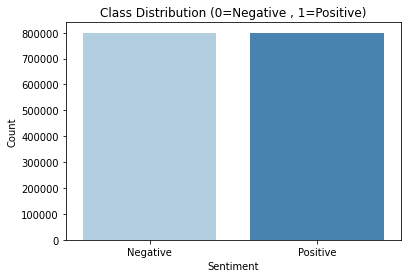

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data = df, palette = 'Blues')
plt.title('Class Distribution (0=Negative , 1=Positive)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [33]:
data_cleaned = df.copy()

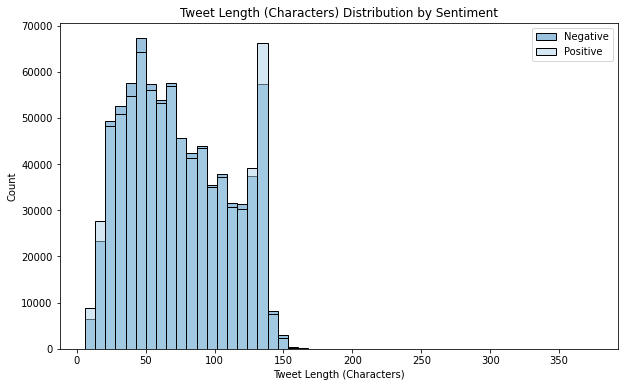

In [34]:
# Sentiment lexicon
positive_words = {'good', 'great', 'awesome', 'happy', 'love', 'excellent', 'wonderful'}
negative_words = {'bad', 'terrible', 'awful', 'hate', 'sad', 'worst', 'poor'}

# Sentiment features
def sentiment_features(text):
    tokens = word_tokenize(text.lower())
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    text_length = len(text)
    word_count = len(tokens)
    return pos_count, neg_count, text_length, word_count


# Preprocess text and add features
data_cleaned[['pos_count', 'neg_count', 'text_length', 'word_count']] = pd.DataFrame(
    data_cleaned['text'].apply(sentiment_features).tolist(), index=data_cleaned.index
)

# Text Characteristics
# Tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data_cleaned, x='text_length', hue='sentiment', bins=50, palette='Blues')
plt.title('Tweet Length (Characters) Distribution by Sentiment')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.savefig('tweet_length_distribution.png')
plt.show()

In [35]:
def create_wordcloud(text_series, title="Word Cloud", max_words=100, figsize=(10, 6), colormap='viridis'):
    """Generate and display a word cloud from a pandas Series."""
    text = " ".join(text_series.astype(str).tolist())
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap=colormap
    ).generate(text)
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [36]:
def create_sentiment_wordclouds(df, text_col, target_col, positive_label=1, negative_label=0):
    """Creates side-by-side word clouds for positive and negative sentiment."""
    
    # Extract text
    positive_text = " ".join(df[df[target_col] == positive_label][text_col].astype(str))
    negative_text = " ".join(df[df[target_col] == negative_label][text_col].astype(str))

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Positive cloud
    pos_wc = WordCloud(
        background_color='white',
        colormap='Greens',
        max_words=120
    ).generate(positive_text)
    axes[0].imshow(pos_wc, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title("Positive Sentiment Word Cloud")

    # Negative cloud
    neg_wc = WordCloud(
        background_color='white',
        colormap='Reds',
        max_words=120
    ).generate(negative_text)
    axes[1].imshow(neg_wc, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title("Negative Sentiment Word Cloud")

    plt.tight_layout()
    plt.show()

In [37]:
# Comprehensive word cloud analysis with multiple visualizations
def create_comprehensive_wordcloud_analysis(df, text_col='text', target_col='target',
                                          positive_label=1, negative_label=0):

    print("Creating comprehensive word cloud analysis...")
    
    # 1. Overall word cloud
    print("1. Overall Word Cloud")
    create_wordcloud(
        df[text_col], 
        title="Overall Word Cloud", 
        max_words=150,
        figsize=(12, 8),
        colormap='viridis'
    )
    
    # 2. Side-by-side sentiment word clouds
    print("2. Sentiment-based Word Clouds")
    create_sentiment_wordclouds(df, text_col, target_col, positive_label, negative_label)
    
    # 3. Individual sentiment word clouds (larger)
    print("3. Individual Sentiment Word Clouds")
    
    # Positive sentiment
    positive_text = df[df[target_col] == positive_label][text_col]
    create_wordcloud(
        positive_text,
        title=f"Positive Sentiment Word Cloud ({len(positive_text)} samples)",
        max_words=120,
        figsize=(12, 8),
        colormap='Greens'
    )
    
    # Negative sentiment
    negative_text = df[df[target_col] == negative_label][text_col]
    create_wordcloud(
        negative_text,
        title=f"Negative Sentiment Word Cloud ({len(negative_text)} samples)",
        max_words=120,
        figsize=(12, 8),
        colormap='Reds'
    )



1. Creating comprehensive word cloud analysis...
Creating comprehensive word cloud analysis...
1. Overall Word Cloud


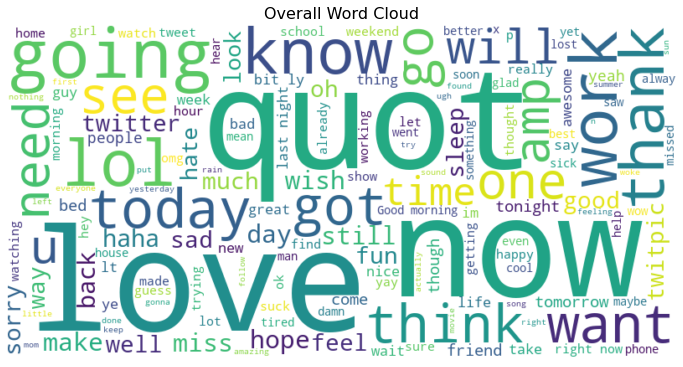

2. Sentiment-based Word Clouds


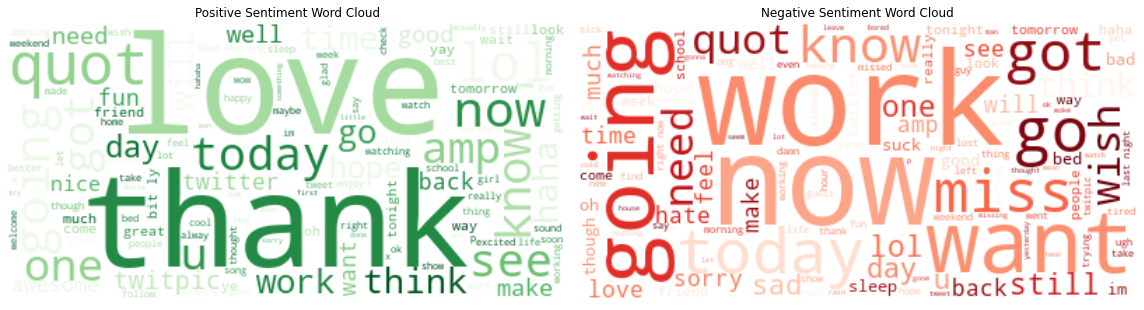

3. Individual Sentiment Word Clouds


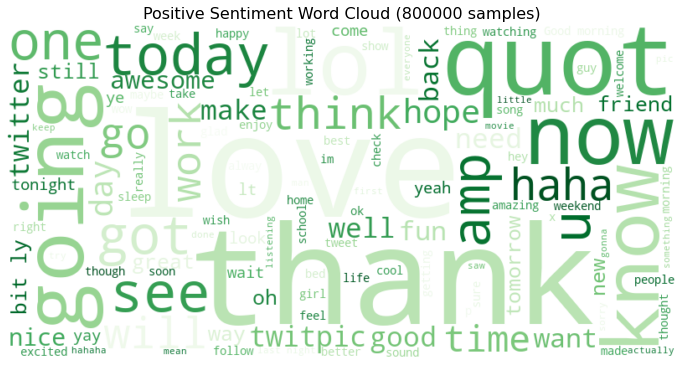

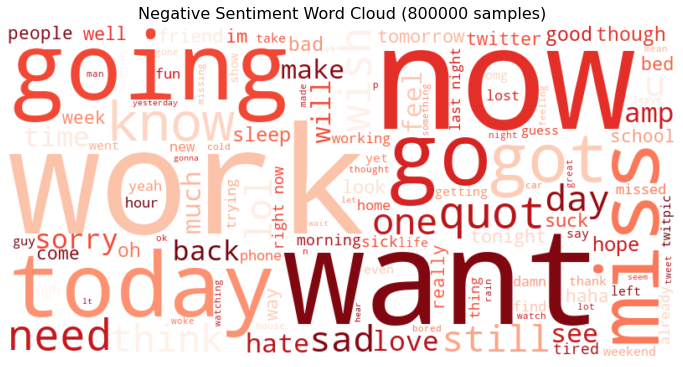

In [38]:
print("\n1. Creating comprehensive word cloud analysis...")
create_comprehensive_wordcloud_analysis(
    data_cleaned, 
    text_col='text',  
    target_col='sentiment',  
    positive_label=1,  
    negative_label=0   
)

In [39]:
# Top word frequencies for overall, positive, and negative sentiment
def plot_word_frequency(df, text_col='text', target_col='target', 
                       positive_label=1, negative_label=0, top_n=15):

    from collections import Counter
    import re
    
    def get_word_freq(text_series):
        # Combine all text and extract words
        combined_text = ' '.join(text_series.astype(str)).lower()
        # Simple word extraction 
        words = re.findall(r'\b[a-zA-Z]{3,}\b', combined_text)
        return Counter(words)
    
    # Get word frequencies
    overall_freq = get_word_freq(df[text_col])
    positive_freq = get_word_freq(df[df[target_col] == positive_label][text_col])
    negative_freq = get_word_freq(df[df[target_col] == negative_label][text_col])
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Overall frequency
    words, counts = zip(*overall_freq.most_common(top_n))
    axes[0].barh(range(len(words)), counts, color='skyblue')
    axes[0].set_yticks(range(len(words)))
    axes[0].set_yticklabels(words)
    axes[0].set_title(f'Top {top_n} Words (Overall)', fontweight='bold')
    axes[0].invert_yaxis()
    
    # Positive frequency
    words, counts = zip(*positive_freq.most_common(top_n))
    axes[1].barh(range(len(words)), counts, color='lightgreen')
    axes[1].set_yticks(range(len(words)))
    axes[1].set_yticklabels(words)
    axes[1].set_title(f'Top {top_n} Words (Positive)', fontweight='bold')
    axes[1].invert_yaxis()
    
    # Negative frequency
    words, counts = zip(*negative_freq.most_common(top_n))
    axes[2].barh(range(len(words)), counts, color='lightcoral')
    axes[2].set_yticks(range(len(words)))
    axes[2].set_yticklabels(words)
    axes[2].set_title(f'Top {top_n} Words (Negative)', fontweight='bold')
    axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()



4. Creating word frequency analysis...


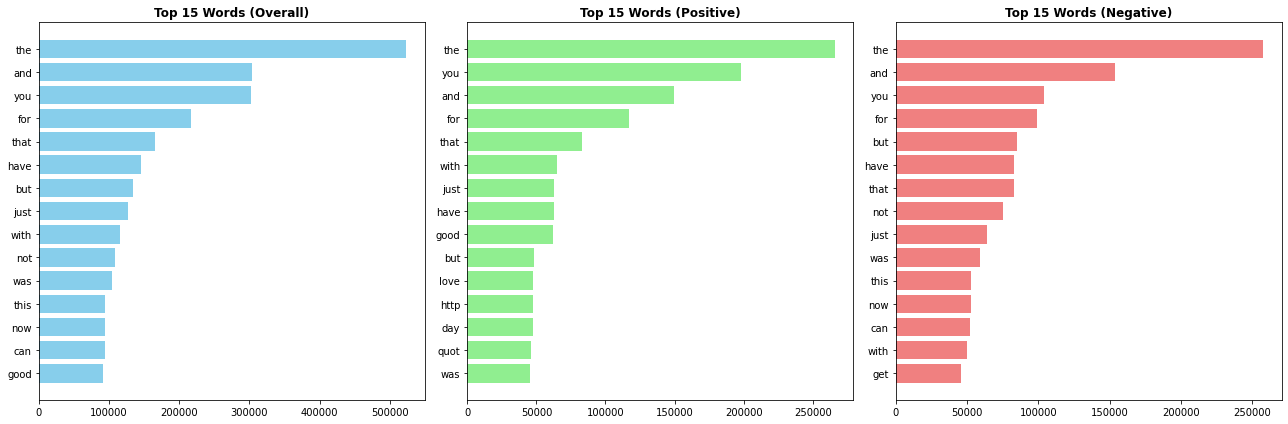

In [40]:
print("\n4. Creating word frequency analysis...")
plot_word_frequency(
    data_cleaned, 
    text_col='text', 
    target_col='sentiment',
    positive_label=1, 
    negative_label=0,
    top_n=15
)

In [41]:
# Custom styled word clouds with different shapes and colors
def create_custom_styled_wordclouds(df, text_col='text', target_col='target',
                                  positive_label=1, negative_label=0):

    # Filter data
    positive_text = ' '.join(df[df[target_col] == positive_label][text_col].astype(str))
    negative_text = ' '.join(df[df[target_col] == negative_label][text_col].astype(str))
    
    # Create custom word clouds with different styles
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Style 1: Positive - Green theme
    wc1 = WordCloud(width=400, height=300, background_color='white', 
                    colormap='Greens', max_words=80, relative_scaling=0.6,
                    random_state=42).generate(positive_text)
    axes[0,0].imshow(wc1, interpolation='bilinear')
    axes[0,0].set_title('Positive Words - Green Theme', fontweight='bold', color='darkgreen')
    axes[0,0].axis('off')
    
    # Style 2: Positive - Blue theme
    wc2 = WordCloud(width=400, height=300, background_color='navy', 
                    colormap='Blues', max_words=80, relative_scaling=0.6,
                    random_state=42).generate(positive_text)
    axes[0,1].imshow(wc2, interpolation='bilinear')
    axes[0,1].set_title('Positive Words - Blue Theme', fontweight='bold', color='darkblue')
    axes[0,1].axis('off')
    
    # Style 3: Negative - Red theme
    wc3 = WordCloud(width=400, height=300, background_color='white', 
                    colormap='Reds', max_words=80, relative_scaling=0.6,
                    random_state=42).generate(negative_text)
    axes[1,0].imshow(wc3, interpolation='bilinear')
    axes[1,0].set_title('Negative Words - Red Theme', fontweight='bold', color='darkred')
    axes[1,0].axis('off')
    
    # Style 4: Negative - Purple theme
    wc4 = WordCloud(width=400, height=300, background_color='black', 
                    colormap='Purples', max_words=80, relative_scaling=0.6,
                    random_state=42).generate(negative_text)
    axes[1,1].imshow(wc4, interpolation='bilinear')
    axes[1,1].set_title('Negative Words - Purple Theme', fontweight='bold', color='purple')
    axes[1,1].axis('off')
    
    plt.suptitle('Custom Styled Word Clouds', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()



5. Creating custom styled word clouds...


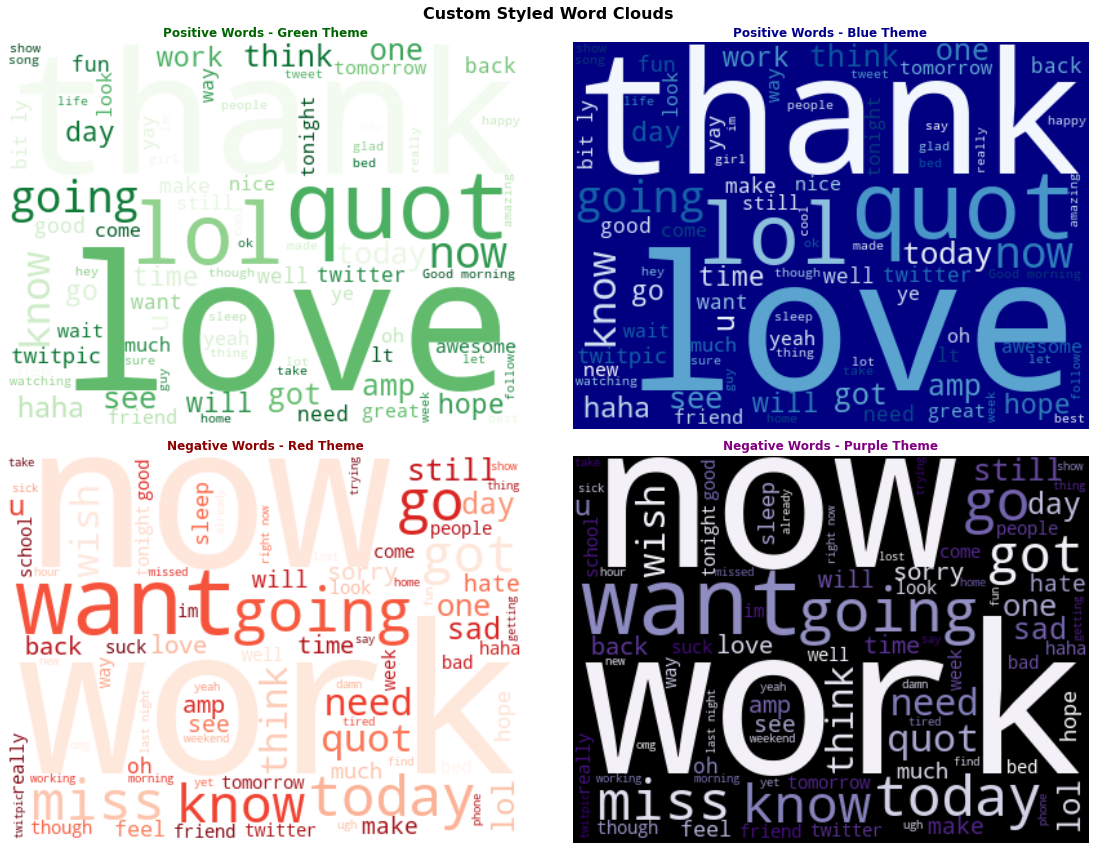

In [42]:
print("\n5. Creating custom styled word clouds...")
create_custom_styled_wordclouds(
    data_cleaned, 
    text_col='text', 
    target_col='sentiment',
    positive_label=1, 
    negative_label=0
)

In [43]:
# Dropping the unnecessary columns
df = df.drop(columns=['id', 'date', 'query', 'user'])

In [44]:
df.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
